In [8]:
import sys, os
sys.path.append('/home/lhc/ST-CCC-benchmarking/SpaOTsc')
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from spaotsc import SpaOTsc
from sklearn.metrics import matthews_corrcoef, average_precision_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.preprocessing import binarize, normalize
from sklearn.mixture import GaussianMixture
from scipy import sparse
import seaborn as sns

%pwd

'/home/lhc/ST-CCC-benchmarking'

In [9]:
def preprocess_pathway(root_dir):
    file_name = 'noise_cc_interactions'
    lrpair_name = 'lrpair.csv'
    pathway_name = 'pathway.csv'

    # ite_dir = './ten_benchmarking_dataset'
    # value_lst = ['_0.3_0.1.csv', '_0.3_0.05.csv', '_0.3_0.csv', '_0.15_0.1.csv', '_0.15_0.csv', '_0.15_0.05.csv']
    # for tissue_n in range(1, 5):
    #     ct_num = 5 if tissue_n <= 2 else 3
    #     for bcmk_n in range(1, 11):
    #         for i in value_lst:
    data_large = pd.read_csv(os.path.join(root_dir, 'cci.csv'))
    grn_data = pd.read_csv(os.path.join(root_dir, 'grn.csv'))
    # * L-R pairs
    filtered = data_large[['ligand', 'receptor']]
    filtered['species'] = 'Human'
    # filtered = filtered.rename(columns={'from': 'ligand', 'target': 'receptor'})
    # filtered = filtered[(filtered['ligand'].str[0] == 'L') & (filtered['receptor'].str[0] == 'R')]
    filtered.index = range(1, filtered.shape[0] + 1)
    filtered.drop_duplicates().to_csv(os.path.join(root_dir, lrpair_name))
    print('finish lrpair', os.path.join(root_dir, lrpair_name))

    # * pathway
    pathway = grn_data[['regulator', 'target']]
    pathway = pathway.rename(columns={'regulator': 'src', 'target': 'dest'})
    pathway['pathway'] = 'Various types of N-glycan biosynthesis'
    pathway['source'] = 'KEGG'
    pathway['type'] = 'Process(missing)'
    pathway['src_tf'] = 'YES'
    pathway['dest_tf'] = 'YES'
    pathway.loc[pathway['dest'].str.slice(4).astype(int) >= 54, 'dest_tf'] = 'NO'
    pathway['species'] = 'Human'
    pathway.index = range(1, pathway.shape[0] + 1)
    pathway.to_csv(os.path.join(root_dir, pathway_name))
    print('finish pathway', os.path.join(root_dir, pathway_name))
    
def self_pcc_mat(x, progress=False):
    x_minus_mu = np.empty_like(x)
    for i in range(x.shape[0]):
        x_minus_mu[i,:] = x[i,:] - np.mean(x[i,:])
    x_std = np.empty([x.shape[0]], float)
    for i in range(x.shape[0]):
        x_std[i] = np.linalg.norm(x_minus_mu[i,:])
        if x_std[i] == 0: x_std[i] = 1
    pmat = np.ones( [x.shape[0], x.shape[0]], float )
    for i in range(x.shape[0]-1):
#         if progress: print(i)
        for j in range(i+1, x.shape[0]):
            c = np.dot(x_minus_mu[i,:], x_minus_mu[j,:]) / (x_std[i]*x_std[j])
            pmat[i,j] = c; pmat[j,i] = c
    return pmat

def get_mcc(true_labels, pred_labels):
    TP = np.sum(np.logical_and(pred_labels == 1, true_labels == 1))
    TN = np.sum(np.logical_and(pred_labels == 0, true_labels == 0))
    FP = np.sum(np.logical_and(pred_labels == 1, true_labels == 0))
    FN = np.sum(np.logical_and(pred_labels == 0, true_labels == 1))
    mcc = (TP * TN) - (FP * FN)
    denom = np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    if denom==0:
        return 0
    return mcc / denom

def preprocess_2(root_dir):
    file_name = 'bcmk_data_position_expression_real_cells.csv'
    sc_file_name = 'bcmk_sc_data_processed.txt'
    bin_file_name = 'sc_isg_binarized.txt'
    mcc_file_name = 'sc_is_mcc.npy'
    pcc_file = 'pcc_pca20.npy'
    df_sc_large = pd.read_csv(os.path.join(root_dir, 'counts.csv'), index_col=0).T
    genes = df_sc_large.columns.values

    # normalize
    df = df_sc_large
    x = np.array( df.values, float )
    x = np.log( x + 1.0 )
    for i in range(x.shape[1]):
        if np.std(x[:,i]) == 0:
            x[:, i] = 0.001
        else:
            x[:,i] = (x[:,i] - np.mean(x[:,i]))/np.std(x[:,i])
    df_new = pd.DataFrame(data=x, columns=df.columns.values, index=df.index.values)
    df_new.to_csv(os.path.join(root_dir, sc_file_name), sep='\t')
    df_sc_large.T.to_csv(os.path.join(root_dir, "giotto_counts.txt"), sep='\t')
    
    pcc_mat = self_pcc_mat(x, progress=True)
    np.save(os.path.join(root_dir, pcc_file), pcc_mat)
    
    df_sc = pd.read_csv(os.path.join(root_dir, sc_file_name), sep='\t', index_col=0)
    genes = df_sc.columns.values
    sp_genes = genes
    sp_genes = list(sp_genes)
    x_sc = np.array( df_sc.values, float )
    sc_genes = list( df_sc.columns.values )
    gind = []
    for g in sp_genes:
        gind.append(sc_genes.index(g))
    gind = np.array(gind, int)
    x_sc = x_sc[:, gind]
    df_sc_part = pd.DataFrame(data=x_sc, columns=sp_genes)
    x_sc_bin = np.empty_like( x_sc )
    for i in range(x_sc.shape[1]):
        GM = GaussianMixture(n_components=2)
        tmp = GM.fit_predict(x_sc[:,i].reshape(-1,1))
    #     print(GM.means_)
        if GM.means_[0,0] > GM.means_[1,0]:
            x_sc_bin[:,i] = 1.0 - tmp[:]
        else:
            x_sc_bin[:,i] = tmp[:]
    df_sc_bin = pd.DataFrame(data=x_sc_bin, columns=sp_genes)
    df_sc_bin.to_csv(os.path.join(root_dir, bin_file_name), sep='\t')
    
    loc_data = pd.read_csv(os.path.join(root_dir, 'locs.csv'), index_col=0)
    loc_data.to_csv(os.path.join(root_dir, 'spatalk_sc_st_data.csv'))
    loc_data.to_csv(os.path.join(root_dir, 'giotto_loc.csv'), header=False, index=False)
    
    print('finish binarized', os.path.join(root_dir, bin_file_name))
    sc_st_data = pd.read_csv(os.path.join(root_dir, 'spatalk_sc_st_data.csv'))
    is_dmat_large =squareform(pdist(sc_st_data.loc[:, ['x', 'y']],metric='euclidean'))
    print(is_dmat_large.shape)
    sparse.save_npz(os.path.join(root_dir, 'is_mat.npz'), sparse.coo_matrix(is_dmat_large))
    
    mcc_all = np.asarray([get_mcc(p, g) for p in x_sc_bin for g in x_sc_bin])
    mcc_all = mcc_all.reshape(len(x_sc_bin),-1)
    np.save(os.path.join(root_dir, mcc_file_name), mcc_all)
    

def run(root_dir):
    # print('START --- ', os.path.join(ite_dir, 'tissue_{}'.format(tissue_n), 'ten_benchmark_data_{}'.format(bcmk_n)))
    sc_st_data = pd.read_csv(os.path.join(root_dir, 'spatalk_sc_st_data.csv'))
    is_dmat_large =squareform(pdist(sc_st_data.loc[:, ['x', 'y']],metric='euclidean'))
    # is_dmat_large = sparse.load_npz(os.path.join(root_dir, 'is_mat.npz')).todense()
    print(is_dmat_large.shape)
    sparse.save_npz(os.path.join(root_dir, 'is_mat.npz'), sparse.coo_matrix(is_dmat_large))
    df_sc = pd.read_csv(os.path.join(root_dir, 'bcmk_sc_data_processed.txt') , sep='\t', index_col=0)
    df_sc_bin = pd.read_csv(os.path.join(root_dir, 'sc_isg_binarized.txt'), sep='\t', index_col=0)

    df_is_bin = df_sc_bin
    sc_pcc = np.load(os.path.join(root_dir, 'pcc_pca20.npy'))
    mcc = np.load(os.path.join(root_dir, 'sc_is_mcc.npy'))
    issc = SpaOTsc.spatial_sc(
        sc_data=df_sc,
        sc_data_bin=df_sc_bin,
        is_data_bin=df_is_bin,
        sc_dmat = np.exp(1-sc_pcc),
        is_dmat=is_dmat_large)

    issc.cell_cell_distance(sc_dmat_spatial=is_dmat_large)
    issc.clustering(pca_n_components=2)
    issc.nonspatial_correlation()
    return issc
    
    
def get_result_sc(root_dir, issc):
    ncell = 400
    loc_data = pd.read_csv(os.path.join(root_dir, 'locs.csv'), index_col=0)
    dist_mat = np.zeros((ncell, ncell))
    for i in range(ncell):
        for j in range(ncell):
            xi = loc_data.iloc[i, 0]
            yi = loc_data.iloc[i, 1]
            xj = loc_data.iloc[j, 0]
            yj = loc_data.iloc[j, 1]
            if (abs(xi - yi) == 1 and xj == yj) or (abs(xj - yj) ==1 and xi == yi):
                dist_mat[i, j] = 1
    np.save(os.path.join(root_dir, f'dist_mat.npy'), dist_mat)
    
    lr_pair = pd.read_csv(os.path.join(root_dir, 'lrpair.csv')).loc[:, ['ligand', 'receptor']]
    cell_info = pd.read_csv(os.path.join(root_dir, 'cell_info.csv'), index_col=0)
    ct_num = len(np.unique(cell_info.loc[:, "cell.type.idx"].to_numpy()))
    idx_dict = {}
    for i in range(1, ct_num+1):
        idx_dict[i] = cell_info['cell.type.idx'] == i
    S_name_a_b = {}
    
    res = np.zeros((ncell, ncell, 6))
    i = 0
    for l, r in lr_pair.values.astype(str):
        # only calculate matched L-P pairs
        # if l[1:] != r[1:]:
        #     continue
        print(f"{i}: {l}-{r}")
        ccc = issc.spatial_signaling_ot([l], [r])
        print(ccc.sum())
        res[:,:,i] = ccc
        i += 1
        # ccc.to_csv(os.path.join(root_dir, f'spaot_results_{l}_{r}.csv'))
    np.save(os.path.join(root_dir, f'spaot_result.npy'), res)

In [10]:
dirs = []

for seed in [1, 2, 3, 4, 5, 6, 7, 8]:
    root_dir = f"/home/lhc/scMultiSim/bench/cci/cci_sc_{seed}/"
    dirs.append(root_dir)

In [58]:
for root_dir in dirs:
    preprocess_pathway(root_dir)
    preprocess_2(root_dir)
    issc = run(root_dir)
    get_result_sc(root_dir, issc)

/tmp/ipykernel_390512/127976735.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['species'] = 'Human'


finish lrpair /home/lhc/scMultiSim/bench/cci/cci_sc2_1/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/cci/cci_sc2_1/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/cci/cci_sc2_1/sc_isg_binarized.txt
(400, 400)
(400, 400)
0 3 [34, 29, 20]
1 3 [34, 12, 12]
2 5 [16, 14, 11, 7, 3]
3 4 [14, 10, 9, 7]
4 4 [15, 10, 9, 5]
5 3 [18, 10, 9]
6 4 [15, 11, 5, 4]
7 6 [12, 7, 5, 4, 1, 1]
8 4 [12, 10, 4, 1]
0 83 gene116
gene116
91
gene110
100
22
0 0 34 gene116
gene116
84
91
106
22
0 1 29 100
100
gene110
91
57
22
0 2 20 gene116
gene116
gene110
72
91
57
1 58 38
38
79
56
15
41
1 0 34 38
38
52
56
85
63
1 1 12 67
67
41
103
38
49
1 2 12 33
33
50
67
72
79
2 51 101
101
gene107
87
gene109
93
2 0 16 101
101
gene108
gene107
gene109
87
2 1 14 101
101
gene107
93
95
81
2 2 11 101
101
87
93
95
gene107
2 3 7 101
101
gene107
74
64
95
3 40 32
32
25
7
43
75
3 0 14 7
7
32
25
19
75
3 1 10 32
32
25
43
34
7
3 2 9 75
75
25
7
32
34
3 3 7 32
32
25
43
8
61
4 39 33
33
71
52
15
56
4 0 15 33
33
52
15
71
97
4 1 10 71
7

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 478
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 939
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 839
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 402
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


1232.015780288455
4: 105-20
1231.965801684693
5: 106-30
794.0382643650771
finish lrpair /home/lhc/scMultiSim/bench/cci/cci_sc2_2/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/cci/cci_sc2_2/pathway.csv


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 471
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 197
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/tmp/ipykernel_390512/127976735.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['species'] = 'Human'


finish binarized /home/lhc/scMultiSim/bench/cci/cci_sc2_2/sc_isg_binarized.txt
(400, 400)
(400, 400)
0 4 [27, 26, 19, 9]
1 3 [39, 24, 13]
2 2 [33, 20]
3 4 [24, 15, 6, 4]
4 5 [12, 10, 8, 5, 5]
5 4 [13, 10, 9, 6]
6 3 [19, 13, 6]
7 7 [6, 4, 4, 4, 3, 3, 1]
0 81 25
25
21
61
75
34
0 0 27 61
61
21
26
19
34
0 1 26 26
26
25
75
61
32
0 2 19 34
34
31
25
gene111
75
0 3 9 26
26
33
29
21
99
1 76 66
66
50
38
94
105
1 0 39 66
66
50
38
gene113
36
1 1 24 66
66
50
94
38
17
1 2 13 66
66
41
38
85
105
2 53 88
88
12
82
36
76
2 0 33 12
12
36
88
82
100
2 1 20 60
60
82
88
76
100
3 49 gene110
gene110
3
105
gene111
78
3 0 24 gene110
gene110
105
3
gene111
78
3 1 15 gene110
gene110
gene111
105
3
20
3 2 6 gene110
gene110
3
96
48
16
3 3 4 gene110
gene110
96
105
gene107
87
4 40 gene118
gene118
102
106
gene108
69
4 0 12 102
102
gene118
gene108
106
25
4 1 10 gene118
gene118
106
102
27
31
4 2 8 102
102
gene118
106
gene108
69
4 3 5 102
102
gene118
106
43
gene108
4 4 5 gene118
gene118
106
gene108
102
69
5 38 61
61
32
75
19

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 611
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: 

728.8622261111827
4: 105-20
1649.1278521078905
5: 106-30
991.0450905373456
finish lrpair /home/lhc/scMultiSim/bench/cci/cci_sc2_3/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/cci/cci_sc2_3/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/cci/cci_sc2_3/sc_isg_binarized.txt
(400, 400)
(400, 400)
0 3 [36, 27, 21]
1 3 [29, 27, 23]
2 3 [20, 19, 18]
3 3 [19, 16, 13]
4 3 [24, 14, 9]
5 5 [12, 11, 7, 6, 1]
6 5 [10, 5, 4, 4, 1]
7 4 [8, 7, 7, 2]
0 84 98
98
72
62
69
35
0 0 36 72
72
98
69
62
55
0 1 27 66
66
72
98
62
69
0 2 21 35
35
98
62
72
66
1 79 gene110
gene110
1
gene119
gene109
6
1 0 29 gene119
gene119
gene110
6
1
53
1 1 27 gene110
gene110
1
gene119
8
10
1 2 23 1
1
gene109
gene110
gene119
10
2 57 gene109
gene109
gene119
gene117
105
gene110
2 0 20 gene109
gene109
gene117
gene119
105
gene120
2 1 19 gene109
gene109
gene117
gene119
83
gene107
2 2 18 gene109
gene109
gene119
gene117
gene110
105
3 48 88
88
74
45
5
36
3 0 19 88
88
45
74
5
36
3 1 16 74
74
88
32
26
45
3 2 13 45
45
74
88
ge

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 361
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 160
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 585
  warnings.warn('Warning: numerical errors at iterat

995.0564836597517
2: 103-10
1136.0261261672078
3: 104-8
2796.6213051537798
4: 105-20


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/tmp/ipykernel_390512/127976735.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['species'] = 'Human'


2936.703354598364
5: 106-30
1283.0661032515839
finish lrpair /home/lhc/scMultiSim/bench/cci/cci_sc2_4/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/cci/cci_sc2_4/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/cci/cci_sc2_4/sc_isg_binarized.txt
(400, 400)
(400, 400)
0 2 [38, 25]
1 3 [25, 24, 13]
2 3 [23, 19, 18]
3 3 [30, 13, 10]
4 5 [21, 9, 9, 6, 5]
5 2 [25, 18]
6 2 [25, 10]
7 3 [16, 11, 7]
0 63 65
65
106
68
57
99
0 0 38 65
65
106
gene108
26
87
0 1 25 65
65
106
68
57
99
1 62 gene116
gene116
105
gene117
4
23
1 0 25 gene116
gene116
105
4
gene117
89
1 1 24 gene116
gene116
gene117
105
4
101
1 2 13 gene116
gene116
gene117
23
4
gene119
2 60 67
67
38
55
71
56
2 0 23 71
71
67
79
56
38
2 1 19 55
55
67
29
38
16
2 2 18 49
49
56
50
79
38
3 53 gene117
gene117
9
gene119
4
38
3 0 30 gene117
gene117
9
gene119
38
89
3 1 13 gene117
gene117
gene119
4
9
38
3 2 10 gene117
gene117
gene119
9
45
4
4 50 101
101
2
gene107
86
96
4 0 21 101
101
2
86
96
gene107
4 1 9 101
101
2
gene107
86
89
4 2 9 10

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 915
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 234
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteratio

1368.4882964581516
finish lrpair /home/lhc/scMultiSim/bench/cci/cci_sc2_5/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/cci/cci_sc2_5/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/cci/cci_sc2_5/sc_isg_binarized.txt
(400, 400)
(400, 400)
0 4 [26, 16, 15, 10]
1 3 [27, 24, 12]
2 4 [16, 14, 11, 11]
3 3 [18, 17, 9]
4 3 [20, 14, 10]
5 4 [16, 7, 7, 5]
6 4 [14, 9, 9, 3]
7 4 [12, 7, 6, 5]
8 4 [13, 10, 6, 1]
0 67 65
65
64
78
57
47
0 0 26 65
65
34
64
57
81
0 1 16 65
65
64
33
31
27
0 2 15 78
78
27
64
48
65
0 3 10 75
75
12
48
87
64
1 63 58
58
36
88
68
45
1 0 27 58
58
45
88
36
68
1 1 24 58
58
36
68
74
88
1 2 12 36
36
74
88
58
45
2 52 36
36
17
88
58
74
2 0 16 36
36
58
88
17
28
2 1 14 58
58
36
17
88
gene108
2 2 11 36
36
74
88
17
28
2 3 11 10
10
17
63
37
52
3 44 gene112
gene112
gene111
104
95
102
3 0 18 gene111
gene111
91
95
gene112
104
3 1 17 gene112
gene112
102
gene111
95
104
3 2 9 gene112
gene112
104
102
76
22
4 44 gene112
gene112
gene117
94
104
95
4 0 20 gene117
gene117
104
gene112

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 333
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or th

1589.173781777047
4: 105-20
1039.116406656739
5: 106-30
606.5529463434376
finish lrpair /home/lhc/scMultiSim/bench/cci/cci_sc2_6/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/cci/cci_sc2_6/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/cci/cci_sc2_6/sc_isg_binarized.txt
(400, 400)
(400, 400)
0 4 [24, 23, 15, 8]
1 3 [28, 19, 16]
2 3 [27, 20, 13]
3 3 [21, 17, 17]
4 4 [16, 16, 8, 3]
5 3 [16, 16, 9]
6 4 [15, 13, 8, 2]
7 5 [9, 8, 6, 5, 2]
0 70 106
106
45
gene107
30
58
0 0 24 106
106
58
45
30
gene115
0 1 23 45
45
gene107
gene109
106
68
0 2 15 gene115
gene115
76
gene109
36
28
0 3 8 gene113
gene113
58
10
30
gene114
1 63 55
55
67
56
42
17
1 0 28 55
55
67
42
56
44
1 1 19 98
98
17
42
56
59
1 2 16 50
50
56
55
67
29
2 60 10
10
8
76
2
14
2 0 27 10
10
76
30
2
8
2 1 20 10
10
76
68
36
8
2 2 13 8
8
10
14
30
2
3 55 101
101
gene120
84
65
82
3 0 21 gene120
gene120
101
84
65
57
3 1 17 101
101
gene120
65
21
53
3 2 17 101
101
84
gene120
82
65
4 43 33
33
75
21
20
32
4 0 16 99
99
21
20
33
65
4 1

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 662
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 828
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 739
  warnings.warn('Warning: numerical errors at iterat

1823.3104035669464
3: 104-8
1960.326860006062
4: 105-20
885.5897583534988
5: 106-30
3091.9594765263073
finish lrpair /home/lhc/scMultiSim/bench/cci/cci_sc2_7/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/cci/cci_sc2_7/pathway.csv


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 506
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/tmp/ipykernel_390512/127976735.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['species'] = 'Human'


finish binarized /home/lhc/scMultiSim/bench/cci/cci_sc2_7/sc_isg_binarized.txt
(400, 400)
(400, 400)
0 4 [22, 18, 18, 13]
1 5 [21, 13, 8, 8, 5]
2 4 [20, 17, 7, 5]
3 4 [25, 11, 8, 4]
4 4 [18, 12, 10, 6]
5 4 [13, 13, 10, 9]
6 5 [11, 11, 7, 4, 3]
7 5 [13, 5, 4, 4, 1]
8 5 [10, 5, 3, 3, 2]
0 71 4
4
78
16
105
106
0 0 22 105
105
106
4
78
16
0 1 18 89
89
106
4
78
105
0 2 18 4
4
91
78
16
105
0 3 13 89
89
16
78
106
3
1 55 gene119
gene119
104
53
gene118
gene108
1 0 21 gene119
gene119
104
gene108
gene118
101
1 1 13 104
104
gene118
gene119
53
gene108
1 2 8 gene119
gene119
93
gene107
57
96
1 3 8 53
53
gene119
84
gene113
104
1 4 5 30
30
gene111
gene119
53
104
2 49 77
77
57
96
33
65
2 0 20 57
57
77
96
gene109
33
2 1 17 77
77
96
65
57
48
2 2 7 77
77
70
32
9
65
2 3 5 77
77
33
31
27
96
3 48 gene112
gene112
91
24
106
16
3 0 25 gene112
gene112
91
24
106
78
3 1 11 24
24
106
gene112
82
22
3 2 8 91
91
gene112
24
37
4
3 3 4 82
82
22
gene112
91
89
4 46 gene107
gene107
104
80
gene109
93
4 0 18 gene107
gene107
93

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 805
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 845
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 308
  warnings.warn('Warning: numerical errors at iterat

905.9777079447011
3: 104-8
1241.9255215787198
4: 105-20
1798.1376172472
5: 106-30
2043.9472199153497
finish lrpair /home/lhc/scMultiSim/bench/cci/cci_sc2_8/lrpair.csv
finish pathway /home/lhc/scMultiSim/bench/cci/cci_sc2_8/pathway.csv
finish binarized /home/lhc/scMultiSim/bench/cci/cci_sc2_8/sc_isg_binarized.txt
(400, 400)
(400, 400)
0 3 [35, 31, 11]
1 2 [50, 25]
2 5 [24, 11, 10, 9, 6]
3 4 [22, 20, 9, 4]
4 4 [17, 16, 12, 7]
5 4 [17, 10, 8, 6]
6 7 [12, 10, 8, 5, 2, 2, 1]
0 77 gene112
gene112
77
103
gene107
96
0 0 35 gene112
gene112
77
gene107
93
96
0 1 31 gene112
gene112
103
77
96
93
0 2 11 gene112
gene112
96
77
gene107
103
1 75 gene110
gene110
98
17
72
92
1 0 50 gene110
gene110
98
17
72
92
1 1 25 17
17
72
11
50
98
2 60 73
73
105
57
gene119
64
2 0 24 73
73
8
57
105
gene119
2 1 11 73
73
105
8
64
gene119
2 2 10 73
73
64
57
105
gene119
2 3 9 73
73
gene119
14
45
8
2 4 6 57
57
105
73
20
88
3 55 75
75
gene113
31
99
gene117
3 0 22 75
75
gene113
gene117
31
99
3 1 20 101
101
31
99
75
32
3 2 9 30

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 795
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 445
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 420
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 260
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


1379.3297794675075
3: 104-8
1699.203484180822
4: 105-20
1480.6847310321004
5: 106-30
1728.820037258378


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


In [14]:
def plot_commot():
    df_plt = pd.DataFrame()
    df_score = []
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    for i in range(2):
        axs[i].set_xlim(0, 1)
    seed = 0
    for root_dir in dirs:
        print(root_dir)
        seed += 1
        cci_gt = np.load(os.path.join(root_dir, "cci_gt.npy"))
        dist_mat = np.load(os.path.join(root_dir, "dist_mat.npy"))
        res = np.load(os.path.join(root_dir, "result_commot/cci_predict_0_20.npy"))
        res_list = np.loadtxt(os.path.join(root_dir, "result_commot/LR_index_0_20.txt"), dtype="str", delimiter="\n")
        res0 = np.repeat(dist_mat[:,:,np.newaxis], 6, axis=2)
        for i in range(6):
            raw_idx = res_list[i].split("-")[2][6:]
            idx = int(raw_idx) - 1
            print(raw_idx, idx)
            res0[:,:,idx] = res[i,:,:]
        
        dist_mat0 = np.repeat(dist_mat[:,:,np.newaxis], 6, axis=2)
        y_true = np.multiply(cci_gt, dist_mat0).flatten()
        
        y_COMMOT = res0.flatten()
        print((y_true > 0).sum())
        print(y_true.shape)
        
        fpr, tpr, _ = roc_curve(y_true, y_COMMOT)
        df_ = pd.DataFrame({ "x": fpr, "y": tpr, "seed": seed, "method": "COMMOT", "metric": "roc"  })
        df_plt = pd.concat([df_plt, df_], ignore_index=True)

        precision, recall, _ = precision_recall_curve(y_true, y_COMMOT)
        df_ = pd.DataFrame({ "x": recall, "y": precision, "seed": seed, "method": "COMMOT", "metric": "prc" })
        df_plt = pd.concat([df_plt, df_], ignore_index=True)
        
        prc = average_precision_score(y_true, y_COMMOT)
        df_score.append({ "x": prc, "seed": seed, "method": "COMMOT", "metric": "AUPRC" })
        roc = roc_auc_score(y_true, y_COMMOT)
        df_score.append({ "x": roc, "seed": seed, "method": "COMMOT", "metric": "AUROC" })

    
    return df_plt, pd.DataFrame(df_score)
        
# plot_commot()

In [4]:
np.loadtxt(os.path.join(root_dir, "result_commot/LR_index_0_20.txt"), dtype="str", delimiter="\n")[0].split('-')[2][6:]

'5'

In [12]:
def plot_spaot():
    df_plt = pd.DataFrame()
    df_score = []
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    for i in range(2):
        axs[i].set_xlim(0, 1)
    seed = 0
    for root_dir in dirs:
        print(root_dir)
        seed += 1
        cci_gt = np.load(os.path.join(root_dir, "cci_gt.npy"))
        res = np.load(os.path.join(root_dir, "spaot_result.npy"))
        dist_mat = np.load(os.path.join(root_dir, "dist_mat.npy"))
        
        dist_mat0 = np.repeat(dist_mat[:,:,np.newaxis], 6, axis=2)
        y_true = np.multiply(cci_gt, dist_mat0).flatten()
        y_spaot = res.flatten()
        
        fpr, tpr, _ = roc_curve(y_true, y_spaot)
        df_ = pd.DataFrame({ "x": fpr, "y": tpr, "seed": seed, "method": "SpaOT", "metric": "roc"  })
        df_plt = pd.concat([df_plt, df_], ignore_index=True)

        precision, recall, _ = precision_recall_curve(y_true, y_spaot)
        df_ = pd.DataFrame({ "x": recall, "y": precision, "seed": seed, "method": "SpaOT", "metric": "prc" })
        df_plt = pd.concat([df_plt, df_], ignore_index=True)
        
        prc = average_precision_score(y_true, y_spaot)
        df_score.append({ "x": prc, "seed": seed, "method": "SpaOT", "metric": "AUPRC" })
        roc = roc_auc_score(y_true, y_spaot)
        df_score.append({ "x": roc, "seed": seed, "method": "SpaOT", "metric": "AUROC" })

    return df_plt, pd.DataFrame(df_score)
        
# plot_spaot()

/home/lhc/scMultiSim/bench/cci/cci_sc_1/
4 3
5 4
1 0
6 5
2 1
3 2
1169
(960000,)
/home/lhc/scMultiSim/bench/cci/cci_sc_2/
3 2
1 0
4 3
6 5
2 1
5 4
3170
(960000,)
/home/lhc/scMultiSim/bench/cci/cci_sc_3/
1 0
5 4
2 1
4 3
3 2
6 5
2302
(960000,)
/home/lhc/scMultiSim/bench/cci/cci_sc_4/
2 1
1 0
5 4
3 2
4 3
6 5
2245
(960000,)
/home/lhc/scMultiSim/bench/cci/cci_sc_5/
6 5
4 3
2 1
5 4
1 0
3 2
1082
(960000,)
/home/lhc/scMultiSim/bench/cci/cci_sc_6/
4 3
6 5
2 1
3 2
1 0
5 4
346
(960000,)
/home/lhc/scMultiSim/bench/cci/cci_sc_7/
2 1
3 2
5 4
1 0
6 5
4 3
1138
(960000,)
/home/lhc/scMultiSim/bench/cci/cci_sc_8/
5 4
1 0
4 3
6 5
2 1
3 2
557
(960000,)
/home/lhc/scMultiSim/bench/cci/cci_sc_1/
/home/lhc/scMultiSim/bench/cci/cci_sc_2/
/home/lhc/scMultiSim/bench/cci/cci_sc_3/
/home/lhc/scMultiSim/bench/cci/cci_sc_4/
/home/lhc/scMultiSim/bench/cci/cci_sc_5/
/home/lhc/scMultiSim/bench/cci/cci_sc_6/
/home/lhc/scMultiSim/bench/cci/cci_sc_7/
/home/lhc/scMultiSim/bench/cci/cci_sc_8/


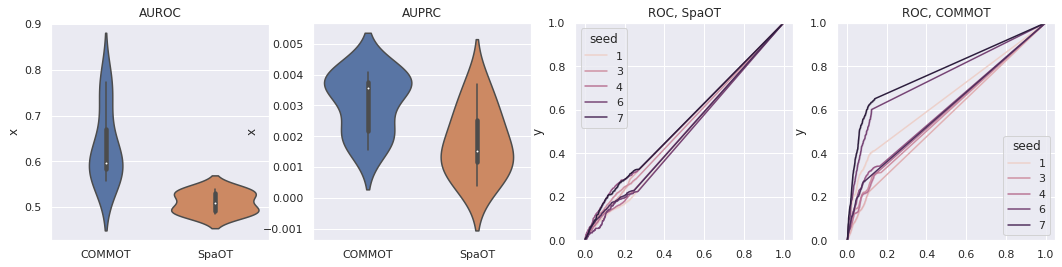

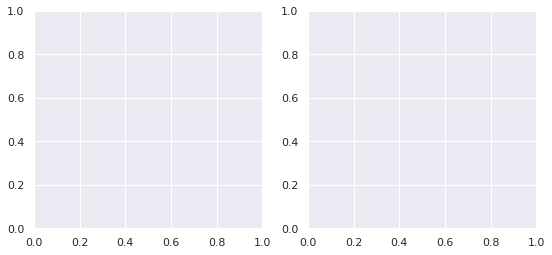

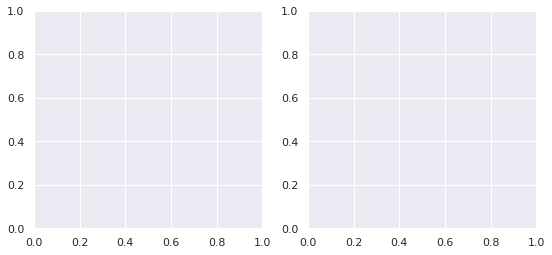

In [15]:
def plot_all():
    sns.set(style="darkgrid")
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))
#     for i in range(4):
#         axs[i].set_xlim(0, 1)
#         axs[i].set_ylim(0, 1)
    
    df_plt1, df_score1 = plot_commot()
    df_plt2, df_score2 = plot_spaot()
    
    df_plt = pd.concat([df_plt1, df_plt2], ignore_index=True)
    df_score = pd.concat([df_score1, df_score2], ignore_index=True)
    
    sns.violinplot(df_score[df_score["metric"] == "AUROC"], y="x", x="method", ax=axs[0]).set(title="AUROC", xlabel="")
    sns.violinplot(df_score[df_score["metric"] == "AUPRC"], y="x", x="method", ax=axs[1]).set(title="AUPRC", xlabel="")
    
    sns.lineplot(df_plt[(df_plt["method"] == "SpaOT") & (df_plt["metric"] == "roc")], x="x", y="y", hue="seed", ax=axs[2]).set(title="ROC, SpaOT", xlabel="", ylim=(0, 1))
    #sns.lineplot(df_plt[(df_plt["method"] == "spaot") & (df_plt["metric"] == "prc")], x="x", y="y", hue="seed", ax=axs[1]).set(title="PRC, spaot", xlabel="", ylim=(0, 1))
    sns.lineplot(df_plt[(df_plt["method"] == "COMMOT") & (df_plt["metric"] == "roc")], x="x", y="y", hue="seed", ax=axs[3]).set(title="ROC, COMMOT", xlabel="", ylim=(0, 1))
    #sns.lineplot(df_plt[(df_plt["method"] == "COMMOT") & (df_plt["metric"] == "prc")], x="x", y="y", hue="seed", ax=axs[1]).set(title="PRC, COMMOT", xlabel="", ylim=(0, 1))
    
    fig.savefig(f"cci_sc.pdf")
plot_all()

In [55]:
def get_results(dirs, talk=False, gio=False):
    df = pd.DataFrame({"method": [], "prc": [], "roc": []})
    df_plt = pd.DataFrame()
    
    dirs = []

    for tree in [5]:
        for ncell in [500, 800]:
            for ngene in [110, 200, 500]:
                for sigma in [0.1, 0.5]:
                    for seed in [1, 2, 3, 4]:
                        root_dir = f"/home/lhc/scMultiSim/bench/unif/0/tree{tree}_{ncell}_cells{ngene}_genes_sigma{sigma}_{seed}/cci/"
                        dirs.append(root_dir)
    
    seed = 0
    count = 0
    for root_dir in dirs:
        seed += 1
        spaot = pd.read_csv(os.path.join(root_dir, 'spaot_results.csv'), index_col=0)
        
        gt = pd.DataFrame(0, index=spaot.index, columns=spaot.columns)
        cci_table = pd.read_csv(os.path.join(root_dir, 'cci.csv'))
        for index, row in cci_table.iterrows():
            gt.loc[f"{row['ligand']}-{row['receptor']}", f"CT{row['ct1']}-CT{row['ct2']}"] = 1
        gt = gt.drop(columns=["CT1-CT1", "CT2-CT2", "CT3-CT3", "CT4-CT4", "CT5-CT5"])
        # print(gt.values.sum() / gt.size)
        spaot = spaot.drop(columns=["CT1-CT1", "CT2-CT2", "CT3-CT3", "CT4-CT4", "CT5-CT5"])
        
        assert spaot.size == gt.size

        y_true = gt.reindex(sorted(gt.columns), axis=1).to_numpy().reshape(-1)
        y_aot = spaot.reindex(sorted(spaot.columns), axis=1).to_numpy().reshape(-1)
        
        if gio:
            giotto = pd.read_csv(os.path.join(root_dir, 'giotto_result_PI.csv'), index_col=0)
            giotto = giotto.drop(columns=["CT1-CT1", "CT2-CT2", "CT3-CT3", "CT4-CT4", "CT5-CT5"])
            y_giotto = giotto.reindex(sorted(giotto.columns), axis=1).to_numpy().reshape(-1)
            # print(spaot.size, giotto.size)
            if (spaot.size != giotto.size):
                continue
            assert spaot.size == giotto.size 
        
        if talk:
            spatalk = pd.read_csv(os.path.join(root_dir, 'spatalk_result.csv'), index_col=0)
            for idx in gt.columns:
                if idx not in spatalk.columns:
                    spatalk[idx] = 0
            y_talk = spatalk.reindex(sorted(spatalk.columns), axis=1).to_numpy().reshape(-1)
            y_talk = 1 - np.clip(y_talk * 120, 0, 1)
            assert spaot.size == spatalk.size 

        # return y_true, y_aot
        
        def get_prc_roc(y_pred):
            prc = average_precision_score(y_true, y_pred)
            roc = roc_auc_score(y_true, y_pred)
            return prc, roc

        if talk:
            df.loc[len(df.index)] = ["spatalk", *get_prc_roc(y_talk)]
        if gio:
            df.loc[len(df.index)] = ["giotto", *get_prc_roc(y_giotto)]
        df.loc[len(df.index)] = ["spaot", *get_prc_roc(y_aot)]
        
        if talk:
            fpr, tpr, _ = roc_curve(y_true, y_talk)
            df_ = pd.DataFrame({ "x": fpr, "y": tpr, "seed": seed, "method": "talk", "metric": "roc"  })
            df_plt = pd.concat([df_plt, df_], ignore_index=True)

            precision, recall, _ = precision_recall_curve(y_true, y_talk)
            df_ = pd.DataFrame({ "x": recall, "y": precision, "seed": seed, "method": "talk", "metric": "prc" })
            df_plt = pd.concat([df_plt, df_], ignore_index=True)
            
        if gio:
            fpr, tpr, _ = roc_curve(y_true, y_giotto)
            df_ = pd.DataFrame({ "x": fpr, "y": tpr, "seed": seed, "method": "giotto", "metric": "roc"  })
            df_plt = pd.concat([df_plt, df_], ignore_index=True)

            precision, recall, _ = precision_recall_curve(y_true, y_giotto)
            df_ = pd.DataFrame({ "x": recall, "y": precision, "seed": seed, "method": "giotto", "metric": "prc" })
            df_plt = pd.concat([df_plt, df_], ignore_index=True)
            
        count += 1
        
        fpr, tpr, _ = roc_curve(y_true, y_aot)
        df_ = pd.DataFrame({ "x": fpr, "y": tpr, "seed": seed, "method": "aot", "metric": "roc" })
        df_plt = pd.concat([df_plt, df_], ignore_index=True)
        
        precision, recall, _ = precision_recall_curve(y_true, y_aot)
        # print(precision, recall)
        df_ = pd.DataFrame({ "x": recall, "y": precision, "seed": seed, "method": "aot", "metric": "prc" })
        df_plt = pd.concat([df_plt, df_], ignore_index=True)
        
    df_plt["seed"] = df_plt["seed"].astype("category")
    sns.set(style="darkgrid")
    
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))
    for i in range(2):
        axs[i].set_xlim(0, 1)
    
    if gio:
        sns.lineplot(df_plt[(df_plt["method"] == "giotto") & (df_plt["metric"] == "roc")], x="x", y="y", hue="seed",  ax=axs[0]).set(title="ROC, giotto", xlabel="", ylim=(0, 1))
        # sns.lineplot(df_plt[(df_plt["method"] == "giotto") & (df_plt["metric"] == "prc")], x="x", y="y", hue="seed", ax=axs[0]).set(title="PRC, giotto", xlabel="", ylim=(0, 1))
    
    sns.lineplot(df_plt[(df_plt["method"] == "aot") & (df_plt["metric"] == "roc")], x="x", y="y", hue="seed", ax=axs[1]).set(title="ROC, spaot", xlabel="", ylim=(0, 1))
    sns.violinplot(df, y="roc", x="method", ax=axs[2]).set(title="AUROC", xlabel="")
    sns.violinplot(df, y="prc", x="method", ax=axs[3]).set(title="AUPRC", xlabel="")
    
    for i in range(2):
        axs[i].legend([],[], frameon=False)
    
    fig.savefig(f"unif_cci_tree5.pdf")
    return df

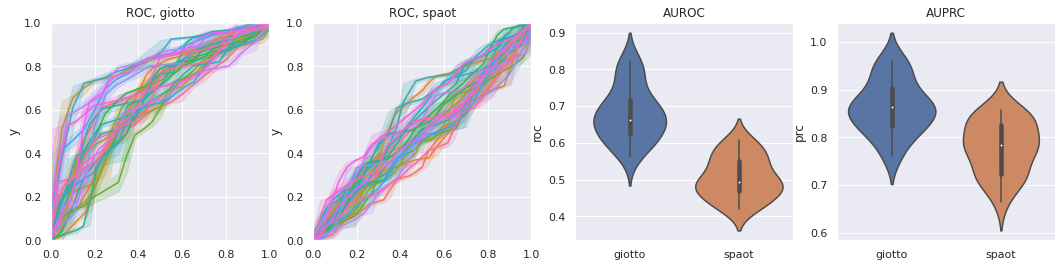

In [56]:
df_plt = get_results(dirs, gio=True)

In [ ]:
def get_results(dirs, talk=False, gio=False):
    df = pd.DataFrame({"method": [], "prc": [], "roc": []})
    df_plt = pd.DataFrame()
    
    dirs = []

    for tree in [1]:
        for ncell in [500, 800]:
            for ngene in [110, 200, 500]:
                for sigma in [0.1, 0.5]:
                    for seed in [1, 2, 3, 4]:
                        root_dir = f"/home/lhc/scMultiSim/bench/unif/0/tree{tree}_{ncell}_cells{ngene}_genes_sigma{sigma}_{seed}/cci/"
                        dirs.append(root_dir)
    
    seed = 0
    count = 0
    for root_dir in dirs:
        seed += 1
        spaot = pd.read_csv(os.path.join(root_dir, 'spaot_results.csv'), index_col=0)
        
        gt = pd.DataFrame(0, index=spaot.index, columns=spaot.columns)
        cci_table = pd.read_csv(os.path.join(root_dir, 'cci.csv'))
        for index, row in cci_table.iterrows():
            gt.loc[f"{row['ligand']}-{row['receptor']}", f"CT{row['ct1']}-CT{row['ct2']}"] = 1
        gt = gt.drop(columns=["CT1-CT1", "CT2-CT2", "CT3-CT3", "CT4-CT4", "CT5-CT5"])
        # print(gt.values.sum() / gt.size)
        spaot = spaot.drop(columns=["CT1-CT1", "CT2-CT2", "CT3-CT3", "CT4-CT4", "CT5-CT5"])
        
        assert spaot.size == gt.size

        y_true = gt.reindex(sorted(gt.columns), axis=1).to_numpy().reshape(-1)
        y_aot = spaot.reindex(sorted(spaot.columns), axis=1).to_numpy().reshape(-1)
        
        if gio:
            giotto = pd.read_csv(os.path.join(root_dir, 'giotto_result_PI.csv'), index_col=0)
            giotto = giotto.drop(columns=["CT1-CT1", "CT2-CT2", "CT3-CT3", "CT4-CT4", "CT5-CT5"])
            y_giotto = giotto.reindex(sorted(giotto.columns), axis=1).to_numpy().reshape(-1)
            # print(spaot.size, giotto.size)
            if (spaot.size != giotto.size):
                continue
            assert spaot.size == giotto.size 
        
        if talk:
            spatalk = pd.read_csv(os.path.join(root_dir, 'spatalk_result.csv'), index_col=0)
            for idx in gt.columns:
                if idx not in spatalk.columns:
                    spatalk[idx] = 0
            y_talk = spatalk.reindex(sorted(spatalk.columns), axis=1).to_numpy().reshape(-1)
            y_talk = 1 - np.clip(y_talk * 120, 0, 1)
            assert spaot.size == spatalk.size 

        # return y_true, y_aot
        
        def get_prc_roc(y_pred):
            prc = average_precision_score(y_true, y_pred)
            roc = roc_auc_score(y_true, y_pred)
            return prc, roc

        if talk:
            df.loc[len(df.index)] = ["spatalk", *get_prc_roc(y_talk)]
        if gio:
            df.loc[len(df.index)] = ["giotto", *get_prc_roc(y_giotto)]
        df.loc[len(df.index)] = ["spaot", *get_prc_roc(y_aot)]
        
        if talk:
            fpr, tpr, _ = roc_curve(y_true, y_talk)
            df_ = pd.DataFrame({ "x": fpr, "y": tpr, "seed": seed, "method": "talk", "metric": "roc"  })
            df_plt = pd.concat([df_plt, df_], ignore_index=True)

            precision, recall, _ = precision_recall_curve(y_true, y_talk)
            df_ = pd.DataFrame({ "x": recall, "y": precision, "seed": seed, "method": "talk", "metric": "prc" })
            df_plt = pd.concat([df_plt, df_], ignore_index=True)
            
        if gio:
            fpr, tpr, _ = roc_curve(y_true, y_giotto)
            df_ = pd.DataFrame({ "x": fpr, "y": tpr, "seed": seed, "method": "giotto", "metric": "roc"  })
            df_plt = pd.concat([df_plt, df_], ignore_index=True)

            precision, recall, _ = precision_recall_curve(y_true, y_giotto)
            df_ = pd.DataFrame({ "x": recall, "y": precision, "seed": seed, "method": "giotto", "metric": "prc" })
            df_plt = pd.concat([df_plt, df_], ignore_index=True)
            
        count += 1
        
        fpr, tpr, _ = roc_curve(y_true, y_aot)
        df_ = pd.DataFrame({ "x": fpr, "y": tpr, "seed": seed, "method": "aot", "metric": "roc" })
        df_plt = pd.concat([df_plt, df_], ignore_index=True)
        
        precision, recall, _ = precision_recall_curve(y_true, y_aot)
        # print(precision, recall)
        df_ = pd.DataFrame({ "x": recall, "y": precision, "seed": seed, "method": "aot", "metric": "prc" })
        df_plt = pd.concat([df_plt, df_], ignore_index=True)
        
    df_plt["seed"] = df_plt["seed"].astype("category")
    sns.set(style="darkgrid")
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
    for i in range(1):
        for j in range(2):
            axs[i, j].set_ylim(0, 1)
            axs[i, j].set_xlim(0, 1)
    if talk:
        sns.lineplot(df_plt[(df_plt["method"] == "talk") & (df_plt["metric"] == "roc")], x="x", y="y", hue="seed",  ax=axs[0, 2]).set(title="ROC, spatalk", ylim=(0, 1))
        sns.lineplot(df_plt[(df_plt["method"] == "talk") & (df_plt["metric"] == "prc")], x="x", y="y", hue="seed", ax=axs[1, 2]).set(title="PRC, spatalk", ylim=(0, 1))
    
    if gio:
        sns.lineplot(df_plt[(df_plt["method"] == "giotto") & (df_plt["metric"] == "roc")], x="x", y="y", hue="seed",  ax=axs[0, 0]).set(title="ROC, giotto", xlabel="", ylim=(0, 1))
        sns.lineplot(df_plt[(df_plt["method"] == "giotto") & (df_plt["metric"] == "prc")], x="x", y="y", hue="seed", ax=axs[1, 0]).set(title="PRC, giotto", xlabel="", ylim=(0, 1))
    
    sns.lineplot(df_plt[(df_plt["method"] == "aot") & (df_plt["metric"] == "roc")], x="x", y="y", hue="seed", ax=axs[0, 1]).set(title="ROC, spaot", xlabel="", ylim=(0, 1))
    sns.lineplot(df_plt[(df_plt["method"] == "aot") & (df_plt["metric"] == "prc")], x="x", y="y", hue="seed", ax=axs[1, 1]).set(title="PRC, spaot", xlabel="", ylim=(0, 1))
    sns.violinplot(df, y="roc", x="method", ax=axs[0, 2]).set(title="AUROC", xlabel="")
    sns.violinplot(df, y="prc", x="method", ax=axs[0, 3]).set(title="AUPRC", xlabel="")
    
    for i in range(1):
        for j in range(2):
            axs[i, j].legend([],[], frameon=False)
    
    fig.savefig(f"unif_cci_tree1.pdf")
    return df